This file contains functions and an example of a product grouping by characteristics. We begin by defining the needed functions and importing data. Characteristics are manually defined as binary variables and added to a "product characteristic" matrix. We first attempt a MeanShift and OPTICS clustering of the products, followed by a custom algorithm.

The grouping is completed using a weighted Hamming Distance(https://en.wikipedia.org/wiki/Hamming_distance) to obtain similarity between products. Products that are similar, based on a similarity threhshold, are grouped. We can consider this function to be a simple clustering algorithm.

The similiarity threshold must be provided as an input. We find this value by analyzing the results of a threshold test, a silhouette score analysis. We can also use a hierarchical clustering as a secondary form of analysis.

Threshold/elbow method: We test a range of similarity threshold values in the grouping function. We plot our results against the number of groups found for each value, and look for any plateaus or sharp changes. 

Silhouette score analysis: We test a range of similarity threshold values in the grouping function and calculate the silhouette score for the resulting groups.This score provide us with an understanding of how well defined the groupings are. We analyze a plot of the similarity threshold values against the results silhouette scores to find an optimum threshold. 

Hierarchical clustering: This is a clustering algorithm that we apply to the products naively to get an understanding of how they group and visualize groupings with a dendrogram.

In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

from utils import *

In [ ]:
#Function to group my hamming distance and similiarity threshold -------------------------------------------------

def group_samples_by_similarity_threshold(matrix, weights, similarity_threshold, columns=feature_cols, index=products):
    # Convert matrix to numpy array if it's not already
    matrix = np.array(matrix)
    weights = np.array(weights)
    
    # Calculate weighted Hamming similarity
    similarity_matrix = weighted_hamming_similarity(matrix, weights)
    
    # Create a DataFrame with the original data
    df = pd.DataFrame(matrix, columns=feature_cols, index=products)
    
    # Initialize groups
    groups = [-1] * len(matrix)
    current_group = 0
    
    for i in range(len(matrix)):
        if groups[i] == -1:
            # Start a new group
            groups[i] = current_group
            # Find all samples similar enough to be in this group
            similar_samples = np.where(similarity_matrix[i] >= similarity_threshold)[0]
            for j in similar_samples:
                if groups[j] == -1:
                    groups[j] = current_group
            current_group += 1
    
    df['group'] = groups
    
    return df

def weighted_hamming_similarity(matrix, weights):
    def weighted_hamming(u, v):
        return np.sum(weights * (u == v)) / np.sum(weights)
    
    distances = pdist(matrix, metric=lambda u, v: 1 - weighted_hamming(u, v))
    return 1 - squareform(distances)

#functions to help find appropriate threshold --------------------------------------------

def elbow_method(matrix, weights, thresholds, feature_cols, products):
    num_groups = []
    for threshold in thresholds:
        result = group_samples_by_similarity_threshold(matrix, weights, threshold, feature_cols, products)
        num_groups.append(result['group'].nunique())
    
    plt.plot(thresholds, num_groups, 'bo-')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Number of Groups')
    plt.title('Elbow Method')
    plt.show()

def silhouette_analysis(matrix, weights, thresholds):
    scores = []
    for threshold in thresholds:
        result = group_samples_by_similarity_threshold(matrix, weights, threshold, feature_cols, products)
        unique_groups = result['group'].nunique()

        if 1 < unique_groups < len(matrix):
            try:
                score = silhouette_score(matrix, result['group'])
                scores.append(score)
            except ValueError as e:
                print(f"Error at threshold {threshold}: {e}")
                scores.append(0)
        else:
            print(f"Invalid number of clusters ({unique_groups}) at threshold {threshold}. Skipping.")
            scores.append(0)
    
    plt.plot(thresholds, scores, 'bo-')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()

def hierarchical_clustering(matrix, weights):
    similarity_matrix = weighted_hamming_similarity(matrix, weights)
    linkage_matrix = linkage(1 - similarity_matrix, method='average')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Products')
    plt.ylabel('Distance')
    plt.show()

def dbscan_clustering(matrix, weights):
    similarity_matrix = weighted_hamming_similarity(matrix, weights)
    distances = 1 - similarity_matrix
    
    dbscan = DBSCAN(metric='precomputed', eps=0.5)  # Adjust eps as needed
    clusters = dbscan.fit_predict(distances)
    
    return clusters

In [2]:
# Load the dataset
biomass_data = pd.read_csv('site_data.csv')

# Transpose the DataFrame to have products as rows and locations as columns
data_transposed = biomass_data.set_index(['dataset', 'site_name', 'site_id', 'X', 'Y']).T

# Remove non-numeric rows
data_transposed_numeric = data_transposed.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

data_imputed

dataset                    NEON                                             \
site_name        Harvard Forest Smithsonian Conservation Biology Institute   
site_id                    HARV                                       SCBI   
X                   -72.172660                                 -78.139500    
Y                     42.536900                                  38.892920   
ESA CCI               21.046901                                  21.046901   
Chopping et al.       18.783055                                  18.783055   
GEDI L4B             164.080719                                 334.279755   
Liu et al.            37.921211                                 115.212837   
LT-GNN                31.403246                                  31.403246   
Menlove & Healey     114.922806                                 106.782768   
Xu et al.             69.325028                                  69.325028   

dataset                                                         \
site_name        Ordway-Swisher Biological Station      UNDERC   
site_id                                       OSBS        UNDE   
X                                      -81.993430  -89.537250    
Y                                        29.689270   46.233880   
ESA CCI                                  21.046901   21.046901   
Chopping et al.                          18.783055   18.783055   
GEDI L4B                                 63.379155  155.069643   
Liu et al.                               69.890287  139.331772   
LT-GNN                                   31.403246   31.403246   
Menlove & Healey                         42.734001   91.699257   
Xu et al.                                69.325028   69.325028   

dataset                                                        \
site_name        Konza Prairie Biological Station   Oak Ridge   
site_id                                      KONZ        ORNL   
X                                     -96.563090  -84.282600    
Y                                       39.100770   35.964120   
ESA CCI                                 21.046901   21.046901   
Chopping et al.                         18.783055   18.783055   
GEDI L4B                                 7.477551  162.482702   
Liu et al.                              10.838812   91.845345   
LT-GNN                                  31.403246   31.403246   
Menlove & Healey                        10.135107  115.705890   
Xu et al.                               69.325028   69.325028   

dataset                                                 \
site_name        Talladega National Forest   Woodworth   
site_id                               TALL        WOOD   
X                              -87.393270  -99.241356    
Y                                32.950460   47.128228   
ESA CCI                          21.046901   21.046901   
Chopping et al.                  18.783055   18.783055   
GEDI L4B                        228.355491    4.161302   
Liu et al.                       85.784576    9.719982   
LT-GNN                           31.403246   31.403246   
Menlove & Healey                125.903267    0.000000   
Xu et al.                        69.325028   69.325028   

dataset                                                                    \
site_name        Central Plains Experimental Range LBJ National Grassland   
site_id                                       CPER                   CLBJ   
X                                      -104.745602            -97.570000    
Y                                        40.815534              33.401230   
ESA CCI                                  21.046901              21.046901   
Chopping et al.                           0.000000              18.783055   
GEDI L4B                                  1.268689              17.868778   
Liu et al.                                9.621728              11.764260   
LT-GNN                                   31.403246              31.403246   
Menlove & Healey      

In [4]:
products = ['ESA CCI', 'Chopping et al.', 'GEDI L4B', 'Liu et al.', 'LT-GNN', 'Menlove & Healey', 'Xu et al.']
feature_cols = ['multispec', 'lidar', 'micro','field','ML']
multispec=np.array([1,1,0,1,1,0,1])
lidar=np.array([1,0,1,0,0,0,0])
micro=np.array([1,0,0,1,0,0,1])
field=np.array([0,0,0,0,1,1,0])
ML=np.array([1,0,0,0,1,0,1])

matrix_unlabeled=np.column_stack((multispec,lidar,micro,field,ML))

In [5]:
matrix_unlabeled

array([[1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1]])

In [6]:
matrix = pd.DataFrame(matrix_unlabeled, columns=feature_cols, index=products)
matrix

,multispec,lidar,micro,field,ML
ESA CCI,1,1,1,0,1
Chopping et al.,1,0,0,0,0
GEDI L4B,0,1,0,0,0
Liu et al.,1,0,1,0,0
LT-GNN,1,0,0,1,1
Menlove & Healey,0,0,0,1,0
Xu et al.,1,0,1,0,1


In [14]:
#attempt to cluster by features with meanshift

scaler = StandardScaler()
prod_data = scaler.fit_transform(matrix)

meanshift = MeanShift()
clusters = meanshift.fit_predict(prod_data)
labels = meanshift.labels_
print("meanshift Cluster labels:", clusters)

get_dist(prod_data, labels)

meanshift Cluster labels: [0 0 2 0 1 3 0]
Distances between cluster centers:
[[0.         2.91958188 3.31269654 3.66387204]
 [2.91958188 0.         4.33397431 2.99722094]
 [3.31269654 4.33397431 0.         3.13049517]
 [3.66387204 2.99722094 3.13049517 0.        ]]

Distances between data points and cluster centers:
Data point 0: [2.00805669 3.72603453 3.61478446 4.78191036]
Data point 1: [1.9036697  2.99722094 3.13049517 3.13049517]
Data point 2: [3.31269654 4.33397431 0.         3.13049517]
Data point 3: [1.25789175 3.61478446 3.72603453 3.72603453]
Data point 4: [2.91958188 0.         4.33397431 2.99722094]
Data point 5: [3.66387204 2.99722094 3.13049517 0.        ]
Data point 6: [1.25789175 2.99722094 4.2387105  4.2387105 ]


In [15]:
#Attempt to cluster with OPTICS

optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(prod_data)
labels = optics.labels_
print("optics Cluster labels:", clusters)

get_dist(prod_data, labels)

optics Cluster labels: [0 0 0 0 0 0 0]
Distances between cluster centers:
[[0.]]

Distances between data points and cluster centers:
Data point 0: [2.44267613]
Data point 1: [1.64316767]
Data point 2: [2.62678511]
Data point 3: [1.81199706]
Data point 4: [2.32020114]
Data point 5: [2.62678511]
Data point 6: [1.96638416]


# Determine Similarity with hamming dist

Use a weighted hamming distance metric to group products by features

In [33]:
weights = [1,1,1,1,1]
similarity_threshold = 0.55

result = group_samples_by_similarity_threshold(matrix, weights, similarity_threshold)
print(result)

                  multispec  lidar  micro  field  ML  group
ESA CCI                   1      1      1      0   1      0
Chopping et al.           1      0      0      0   0      1
GEDI L4B                  0      1      0      0   0      1
Liu et al.                1      0      1      0   0      0
LT-GNN                    1      0      0      1   1      1
Menlove & Healey          0      0      0      1   0      1
Xu et al.                 1      0      1      0   1      0


# Determining appropriate similarity threshold

This can be done using multiple methods and inspection of results:

    elbow method - Look for an "elbow" in the resulting plot where the number of groups starts to level off
    silhouette - Choose the threshold that maximizes the silhouette score,  measures how similar an object is to its own
        cluster compared to other clusters
    hierarchical clustering - Examine the dendrogram to identify natural clusters and choose a threshold that creates these
        clusters

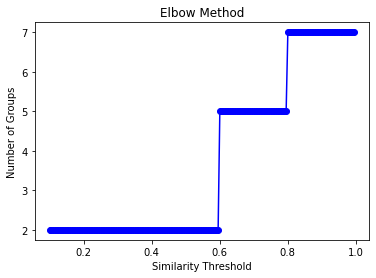

In [20]:
thresholds = np.arange(0.1, 1.0, 0.005)
elbow_method(matrix, weights, thresholds, feature_cols, products)

Invalid number of clusters (7) at threshold 0.8000000000000002. Skipping.
Invalid number of clusters (7) at threshold 0.8500000000000002. Skipping.
Invalid number of clusters (7) at threshold 0.9000000000000002. Skipping.
Invalid number of clusters (7) at threshold 0.9500000000000003. Skipping.


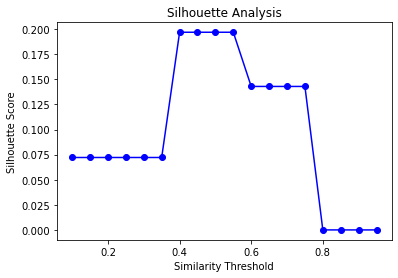

In [34]:
thresholds = np.arange(0.1, 1.0, 0.05)
silhouette_analysis(matrix, weights, thresholds)

In [36]:
similarity_matrix = weighted_hamming_similarity(matrix, weights)
similarity_matrix

array([[1. , 0.4, 0.4, 0.6, 0.4, 0. , 0.8],
       [0.4, 1. , 0.6, 0.8, 0.6, 0.6, 0.6],
       [0.4, 0.6, 1. , 0.4, 0.2, 0.6, 0.2],
       [0.6, 0.8, 0.4, 1. , 0.4, 0.4, 0.8],
       [0.4, 0.6, 0.2, 0.4, 1. , 0.6, 0.6],
       [0. , 0.6, 0.6, 0.4, 0.6, 1. , 0.2],
       [0.8, 0.6, 0.2, 0.8, 0.6, 0.2, 1. ]])

In [37]:
linkage_matrix = linkage(1 - similarity_matrix, method='average')
linkage_matrix

<ipython-input-37-4442d300463f>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - similarity_matrix, method='average')


array([[ 0.        ,  6.        ,  0.52915026,  2.        ],
       [ 1.        ,  3.        ,  0.52915026,  2.        ],
       [ 2.        ,  5.        ,  0.8       ,  2.        ],
       [ 7.        ,  8.        ,  0.83428258,  4.        ],
       [ 4.        , 10.        ,  0.94178659,  5.        ],
       [ 9.        , 11.        ,  1.1964588 ,  7.        ]])

<ipython-input-38-961a38bc7581>:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - similarity_matrix, method='average')


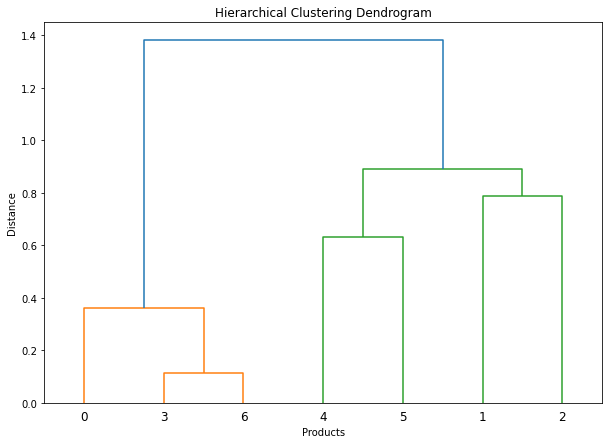

In [38]:
hierarchical_clustering(matrix, weights)

In [16]:
clusters = dbscan_clustering(matrix, weights)
print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")

Number of clusters: 1
